### README

#### Weather Regime Clustering

**Overview**

This script performs clustering on zg500 weather data to identify distinct weather regimes. It includes the generation of cluster centroids based on a specific year and assigns individual runs to pre-existing clusters. This approach is used to prevent memory issues. The script uses Empirical Orthogonal Functions (EOFs), Principal Components (PCs), and KMeans clustering.

#### Instructions

**Prerequisites**
- Install required Python packages: `pandas`, `numpy`, `scikit-learn`, `xarray`, `cfgrib` (if the data is in GRIB format), `dask`, `netcdf4`, `eofs`.
- zg500 geopotential height data in Grib or NetCDF format is required.

**Configuration**
1. **File Paths:** Modify the `PATH` variable according to the location of your zg500 weather data.
2. **Constants:** Adjust constants such as `VERSION`, `USE_SCALING`, `N_EOFS`, `N_EOFS_FOR_KMEANS`, and `N_CLUSTERS` based on your preferences.
3. **Output Directory:** Update the `dir_Clusters` variable to specify where the cluster results will be saved.

**Author**

Bram van Duinen

**Date (last modified)**

2024-01-19

**Reference**

Adapted from: [Matteo De Felice's Recipe for Weather Regimes](https://github.com/matteodefelice/a-recipe-for-weather-regimes/blob/main/recipe.ipynb) (28 Nov 2023)

In [1]:
#REF: https://github.com/matteodefelice/a-recipe-for-weather-regimes/blob/main/recipe.ipynb
#TODO: Check license

### 1. Preliminaries

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
from eofs.xarray import Eof
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from scipy.stats import pearsonr
from tqdm.notebook import tqdm
import time
import utils as ut

In [3]:
PATH = "/net/pc230050/nobackup/users/duinen/LENTIS/present/zg500_d/"
# PATH_CLIM = "/net/pc230050/nobackup/users/duinen/LENTIS/present/climatology/"
# clim = xr.open_dataset(PATH_CLIM + 'clim_zg500.nc').zg500
clim_raw = xr.open_dataset("../Data/clim_zg500_v1.nc")
# constants
VERSION = 4 # update this when you change the clustering algorithm and want to save the new results
USE_SCALING = 0
N_EOFS = 30
N_EOFS_FOR_KMEANS = 20
N_CLUSTERS = 4

dir_Clusters = f"../Results/clusters_v{VERSION}/"
ut.check_make_dir(dir_Clusters)

### 2. Define functions

In [4]:
def load_data(year, run_mid = 90):
    """
    Load and preprocess zg500 data for a specific year, to calculate cluster centroids.

    Parameters:
    - year (int): The target year for data extraction.
    - run_mid (int): The middle run index for splitting the data.

    Returns:
    - df (xarray.DataArray): Preprocessed zg500 data.
    - len_per_run (int): Length of data per run.
    """
    filenames_1 = [f"{PATH}zg500_d_ECEarth3_h{i:03d}.nc" for i in range(10, run_mid)] 
    filenames_2 = [f"{PATH}zg500_d_ECEarth3_h{i:03d}.nc" for i in range(run_mid, 170)]

    df_1 = (
        xr.open_mfdataset(filenames_1, concat_dim='time', combine="nested",
                        chunks={'longitude':31, 
                                'latitude': 16,
                                'time': -1})
        # .convert_calendar('noleap')
    )
    df_1 = df_1.where(
        (df_1['time'].dt.month.isin([10, 11, 12, 1, 2, 3, 4])) & 
        (df_1['time'].dt.year.isin([year])) & # only use one year per run for cluster centroids, add others later.
        (df_1['lon'] < 30) & 
        (df_1['lat'] > 20) & 
        (df_1['lat'] < 80), 
        drop=True
    )

    len_per_run = int(len(df_1.time) / len(range(10, run_mid)))

    df_2 = (
        xr.open_mfdataset(filenames_2, concat_dim='time', combine="nested",
                        chunks={'longitude':31, 
                                'latitude': 16,
                                'time': -1})
        # .convert_calendar('noleap')
    )
    df_2 = df_2.where(
        (df_2['time'].dt.month.isin([10, 11, 12, 1, 2, 3, 4])) & 
        (df_2['time'].dt.year.isin([year])) & # only use one year per run for cluster centroids, add others later.
        (df_2['lon'] < 30) & 
        (df_2['lat'] > 20) & 
        (df_2['lat'] < 80), 
        drop=True
    )
    
    df = xr.concat([df_1, df_2], dim = 'time')
    df = df.zg500.coarsen(lon = 3).mean().coarsen(lat = 3, boundary = 'trim').mean()
    return df, len_per_run

In [5]:
def load_data_per_run(run):
    """
    Load and preprocess zg500 data for a specific run.

    Parameters:
    - run (int): The run index for data extraction.

    Returns:
    - df (xarray.DataArray): Preprocessed zg500 data for the given run.
    """
    filename = [f"{PATH}zg500_d_ECEarth3_h{run:03d}.nc"] 

    df = (
        xr.open_mfdataset(filename)
        # .convert_calendar('noleap') #REVIEW: If it still works with noleap!
    )

    df = df.where(
        (df['time'].dt.month.isin([10, 11, 12, 1, 2, 3, 4])) & 
        (df['lon'] < 30) & 
        (df['lat'] > 20) & 
        (df['lat'] < 80), 
        drop=True
    )

    df = df.zg500.coarsen(lon = 3).mean().coarsen(lat = 3, boundary = 'trim').mean()
    return df

In [6]:
def calculate_anomaly(da, groupby_type="time.dayofyear"):
    """
    Calculate anomalies based on a given grouping type (default = dayofyear).

    Parameters:
    - da (xarray.DataArray): Input climate data.
    - groupby_type (str): Grouping type for calculating anomalies.

    Returns:
    - Anomalies (xarray.DataArray): Calculated anomalies.
    """
    gb = da.groupby(groupby_type)
    clim = gb.mean(dim="time")
    return gb - clim

In [7]:
def calculate_eofs(df_anom):
    """
    Calculate Empirical Orthogonal Functions (EOFs) from anomaly data.

    Parameters:
    - df_anom (xarray.DataArray): Anomaly data.

    Returns:
    - solver, eofs, eofs_corr, explained_var: EOF-related results.
    """
    coslat = np.cos(np.deg2rad(df_anom.coords['lat'].values)).clip(0., 1.)
    wgts   = np.sqrt(coslat)[..., np.newaxis]
    solver = Eof(df_anom, weights=wgts)
    eofs = solver.eofs(neofs=N_EOFS)
    eofs_corr = solver.eofsAsCorrelation(neofs=N_EOFS)
    explained_var = solver.varianceFraction()
    return solver, eofs, eofs_corr, explained_var #REVIEW: if I really need all this

In [8]:
def calculate_pcs(solver, df_anom):
    """
    Calculate Principal Components (PCs) from solver and zg500 anomaly data.

    Parameters:
    - solver: EOF solver.
    - df_anom (xarray.DataArray): Anomaly data.

    Returns:
    - df_pcs (pd.DataFrame): Principal Components data.
    """
    pcs = solver.projectField(df_anom,
                          neofs=N_EOFS, 
                          eofscaling=USE_SCALING)

    df_pcs = (pcs
            .to_dataframe()
            .reset_index()
            .assign(run_index=lambda df: df.groupby(['time', 'mode']).cumcount())
            .pivot(index=['time', 'run_index'], columns='mode', values='pseudo_pcs')
            .add_prefix('EOF')
            )
    df_pcs.index = pd.to_datetime(df_pcs.index.get_level_values('time'))
    return df_pcs

In [9]:
def Kmeans_clustering(df_pcs):
    """
    Perform KMeans clustering on Principal Components.

    Parameters:
    - df_pcs (pd.DataFrame): Principal Components.

    Returns:
    - clus, cluster_center_array: Cluster assignments and centroids.
    """
    X_train = df_pcs.iloc[:, 0:N_EOFS_FOR_KMEANS].values
    km = KMeans(n_clusters=N_CLUSTERS, n_init=500, verbose=0, tol=0.000001, max_iter=500, random_state=3)
    km.fit(X_train)

    clus = pd.DataFrame(
        data=km.labels_, 
        columns=['cluster_id'], 
        index=df_pcs.index).reset_index()
    clus.rename(columns={'time': 'date'}, inplace=True)

    clus.set_index('date', inplace=True)

    # calculate centroids
    cluster_centers = pd.DataFrame(
        km.cluster_centers_, 
        columns=[f'eof{i}' for i in np.arange(1,N_EOFS_FOR_KMEANS+1)]
        )

    cluster_center_array = xr.DataArray(
        cluster_centers.values, 
        coords=[np.arange(0, N_CLUSTERS), np.arange(0, N_EOFS_FOR_KMEANS) ], 
        dims=['centroids', 'mode'])
    
    return clus, cluster_center_array

In [10]:
def original_space(cluster_center_array, eofs):
    """
    Transform cluster centroids from EOF space back to the original space.

    Parameters:
    - cluster_center_array: Centroids in EOF space.
    - eofs: Empirical Orthogonal Functions.

    Returns:
    - recons_cluster_centers_unweighted: Transformed cluster centroids.
    """
    eigenvectors20 = eofs.loc[0:N_EOFS_FOR_KMEANS, ...]
    recons_cluster_centers_weighted = cluster_center_array.dot(eigenvectors20)

    lons = recons_cluster_centers_weighted.coords['lon'].values 
    lats = recons_cluster_centers_weighted.coords['lat'].values

    coslat = np.cos(np.deg2rad(lats)).clip(0., 1.)
    wgts = np.sqrt(coslat)

    weights_array = xr.DataArray(wgts, coords=[lats], dims=['lat'])
    recons_cluster_centers_unweighted = recons_cluster_centers_weighted / weights_array
    return recons_cluster_centers_unweighted

In [22]:
def plot_clusters(recons_cluster_centers_unweighted, lons, lats):
    """
    Plot zg500 clusters on a map.

    Parameters:
    - recons_cluster_centers_unweighted: Transformed cluster centers.
    - lons, lats: Longitude and Latitude values.
    """
    n_clusters = recons_cluster_centers_unweighted.shape[0]

    fig, axs = plt.subplots(2, 2, figsize=(9, 6),
                            subplot_kw={'projection': ccrs.Orthographic(central_longitude=-30, central_latitude=50)})

    axs = axs.flatten()
    titles = ['Blocking', 'Atl. Ridge', 'NAO +', 'NAO -']
    for i, ax in enumerate(axs):
        if i < n_clusters:
            vals = recons_cluster_centers_unweighted[i, :, :].squeeze().values

            fill = ax.contourf(
                lons,
                lats,
                recons_cluster_centers_unweighted[i, :, :].squeeze(),
                levels=np.linspace(-200, 200, 21),
                cmap=plt.cm.RdBu_r,
                extend='both',
                transform=ccrs.PlateCarree())

            ax.coastlines(resolution='50m')
            ax.gridlines()
            ax.set_title(titles[i], fontsize=12)

    cbar_ax = fig.add_axes([0.92, 0.25, 0.015, 0.5])
    cb = fig.colorbar(fill, cax=cbar_ax, orientation='vertical', label='500 hPa height anomaly [m]', extend='both', ticks=np.arange(-200, 250, 50))


In [12]:
def assign_cluster_df(X_assign, centroids, run_id, df):
    """
    Assign data points to clusters based on distances.

    Parameters:
    - X_assign: Data points to assign.
    - centroids: Cluster centroids.
    - run_id: Run identifier.
    - df: Original dataset with the data points.

    Returns:
    - df_cluster: Dataframe with cluster assignments.
    """
    assignments = []
    for data_point in X_assign:
        distances = np.linalg.norm(centroids - data_point, axis=1)
        cluster_assignment = np.argmin(distances)
        assignments.append(cluster_assignment)
  
    df_cluster = pd.DataFrame({
        'time': df['time'].values,
        'run': run_id,
        'cluster_id': assignments
    })

    return df_cluster

In [13]:
#TODO: Add this part, make sure it works also for the later assigned clusters

# # Assume 'kmeans' is your trained KMeans model and 'data' is your dataset
# cluster_centers = km.cluster_centers_

# # Get the cluster assignment for each sample
# labels = km.labels_

# # Initialize an empty list to store the correlation coefficients
# correlation_coefficients = []

# # For each sample, calculate the Pearson correlation coefficient with its assigned cluster center
# for i in tqdm(range(len(X_train))):
#     corr, _ = pearsonr(X_train[i], cluster_centers[labels[i]])
#     correlation_coefficients.append(corr)
# #add the correlation coefficients to the dataframe
# clus['centroid_similarity'] = correlation_coefficients

In [14]:
def gen_clusters(year = 2005):
    """
    Generate zg500 cluster centroids based on a specific year.

    Parameters:
    - year (int): The target year for cluster generation.

    Returns:
    - clus, cluster_center_array, recons_cluster_centers_unweighted, solver, eofs: Cluster-related results.
    """
    print(f"Generating clusters for base year {year}")
    print("Loading data")
    df, len_per_run = load_data(year)
    
    print("Calculating anomalies")
    start_time = time.time()
    df_anom = df.map_blocks(calculate_anomaly, template=df.load())
    # df_anom['time'] = df_anom.indexes['time'].to_datetimeindex()
    end_time = time.time()
    print(f"Anomalies calculated in {end_time - start_time} seconds")

    print("Calculating EOFs")
    solver, eofs, eofs_corr, explained_var = calculate_eofs(df_anom)

    print("Calculating PCs")
    df_pcs = calculate_pcs(solver, df_anom)

    print("Performing clustering")
    clus, cluster_center_array = Kmeans_clustering(df_pcs)
    recons_cluster_centers_unweighted = original_space(cluster_center_array, eofs)

    return clus, cluster_center_array, recons_cluster_centers_unweighted, solver, eofs

In [15]:
def assign_to_cluster(run, centroids, eofs, solver):
    """
    Assign individual runs to pre-existing clusters.

    Parameters:
    - run (int): Run index for assignment.
    - centroids: Cluster centroids (in EOF-space).
    - eofs: Empirical Orthogonal Functions.
    - solver: EOF solver.
    """
    df = load_data_per_run(run)    
    df_anom = df.map_blocks(calculate_anomaly, template=df.load())
    # df_anom['time'] = df_anom.indexes['time'].to_datetimeindex()
    df_pcs = calculate_pcs(solver, df_anom)
    X_assign = df_pcs.iloc[:, 0:N_EOFS_FOR_KMEANS].values

    assignments = []
    all_errors = [[]]
    
    for data_point in X_assign:
        distances = np.linalg.norm(centroids - data_point, axis=1)
        # this part to add no-regime part if there is no significant improvement
        sorted_distances = np.sort(distances)
        if sorted_distances[1] <= sorted_distances[0] * 1.05: # cluster should be significantly better
            cluster_assignment = 4 # no regime
        else:
            cluster_assignment = np.argmin(distances)
        assignments.append(cluster_assignment)
        all_errors = np.append(all_errors, distances)
    
    df_cluster = pd.DataFrame({
        'time': df['time'].values,
        'run': run,
        'cluster_id': assignments,
    })
    return df_cluster


In [16]:
def assign_to_cluster_v2(run, centroids):
    """
    Assign individual runs to pre-existing clusters. 
    Also calculate pattern correlation, and apply no-cluster if correlation is too low.

    Parameters:
    - run (int): Run index for assignment.
    - centroids: Cluster centroids (in real space).
    """
    df = load_data_per_run(run)    
    df_anom = df.map_blocks(calculate_anomaly, template=df.load())
    # df_anom['time'] = df_anom.indexes['time'].to_datetimeindex()

    assignments = []
    all_errors = [[]]
    correlations = []
    
    for data_point in df_anom:
        distances = np.linalg.norm(centroids - data_point, axis=(1,2))
        # this part to add no-regime part if there is no significant improvement
        cluster_assignment = np.argmin(distances)
        corr = np.corrcoef(data_point.values.flatten(), centroids[cluster_assignment].values.flatten())[0, 1]
        if corr < 0.3:
            cluster_assignment = 4

        assignments.append(cluster_assignment)
        all_errors = np.append(all_errors, distances)
        correlations.append(corr)
    
    df_cluster = pd.DataFrame({
        'time': df['time'].values,
        'run': run,
        'cluster_id': assignments,
        'correlation': correlations
    })
    return df_cluster


### 3. Performing clustering
First generate centroids based on one year for all runs. Then assign to cluster per run. This approach prevents memory issues, while achieving the same result.

In [17]:
clus, cluster_center_array, recons_cluster_centers_unweighted, solver, eofs = gen_clusters()

Generating clusters for base year 2005
Loading data


Calculating anomalies
Anomalies calculated in 383.2518756389618 seconds
Calculating EOFs
Calculating PCs
Performing clustering


Plot overview of regime centroids

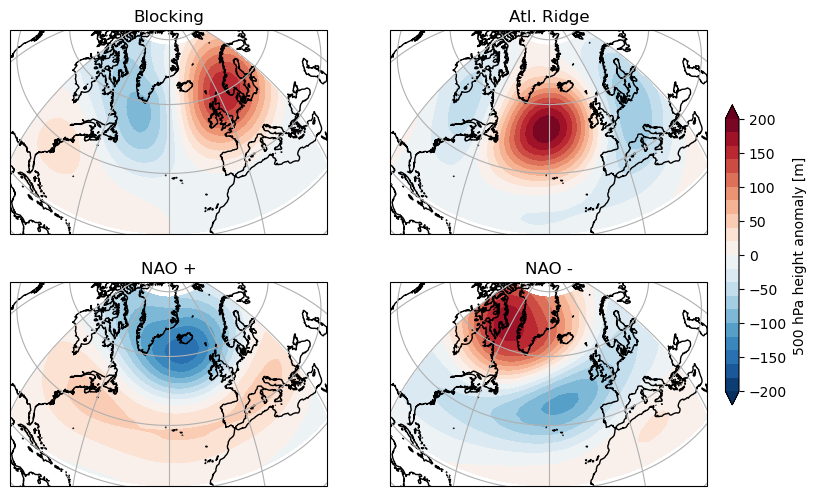

In [23]:
lons = recons_cluster_centers_unweighted.coords['lon'].values 
lats = recons_cluster_centers_unweighted.coords['lat'].values

plot_clusters(recons_cluster_centers_unweighted, lons, lats)

Assign the data of every run to the pre-calculated weather regimes.

In [19]:
#REVIEW: If it still works with noleap! 
for run in tqdm(range(10, 170)):
    df_cluster = assign_to_cluster_v2(run, recons_cluster_centers_unweighted)
    df_cluster.to_csv(f'{dir_Clusters}clusters_{run}.csv')

  0%|          | 0/160 [00:00<?, ?it/s]

### Appendix: Not necessary, but gives some insight

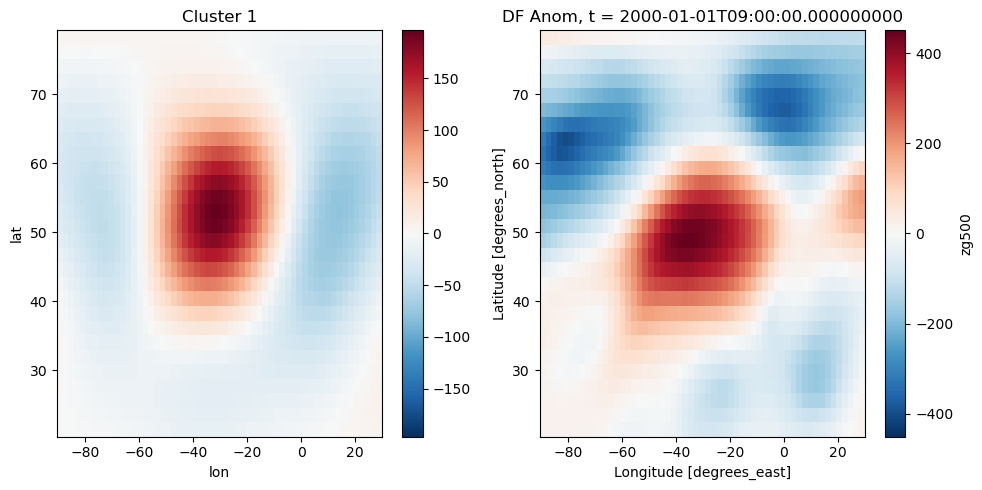

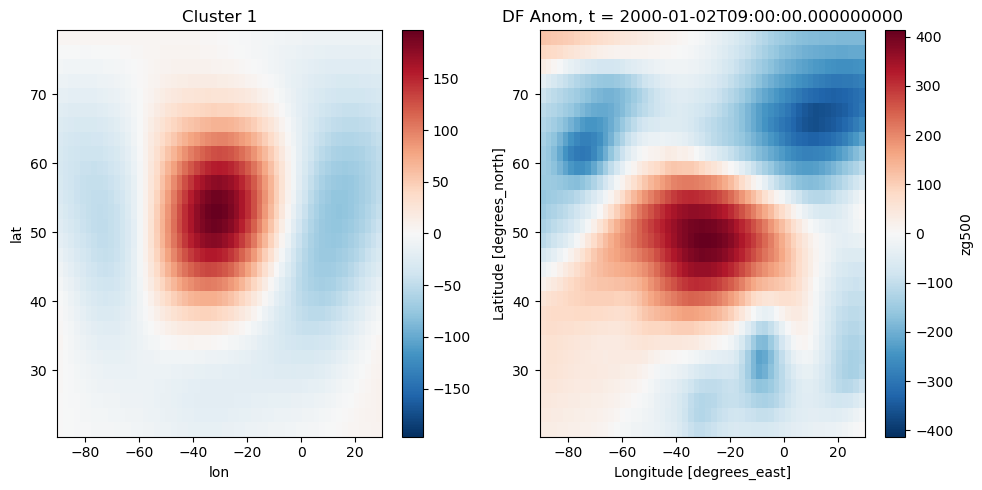

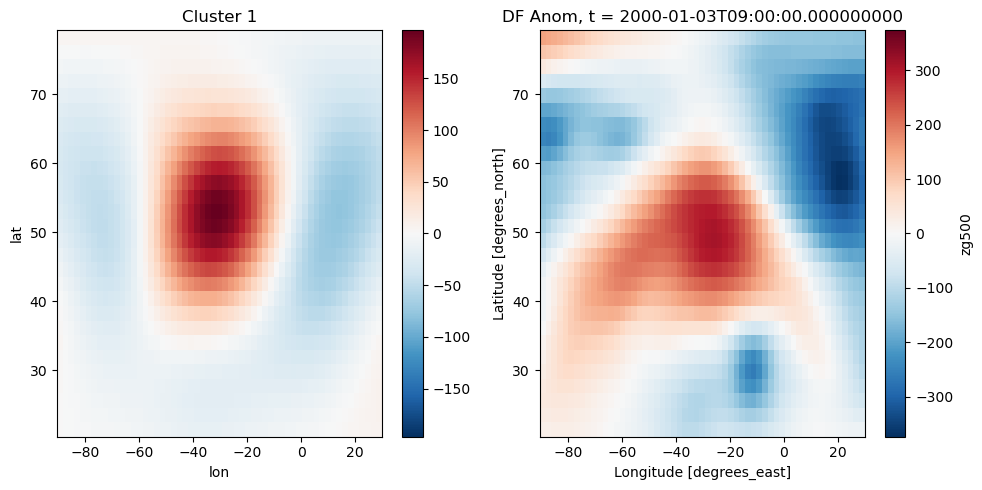

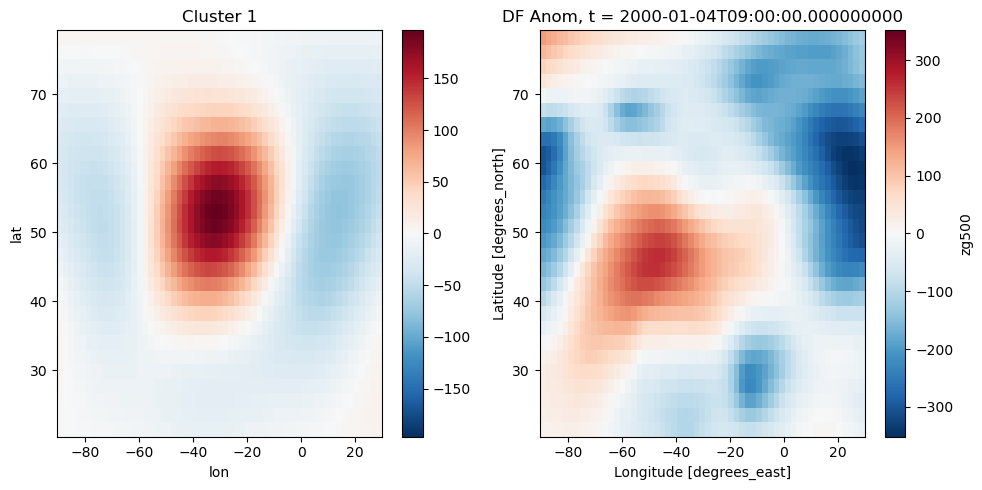

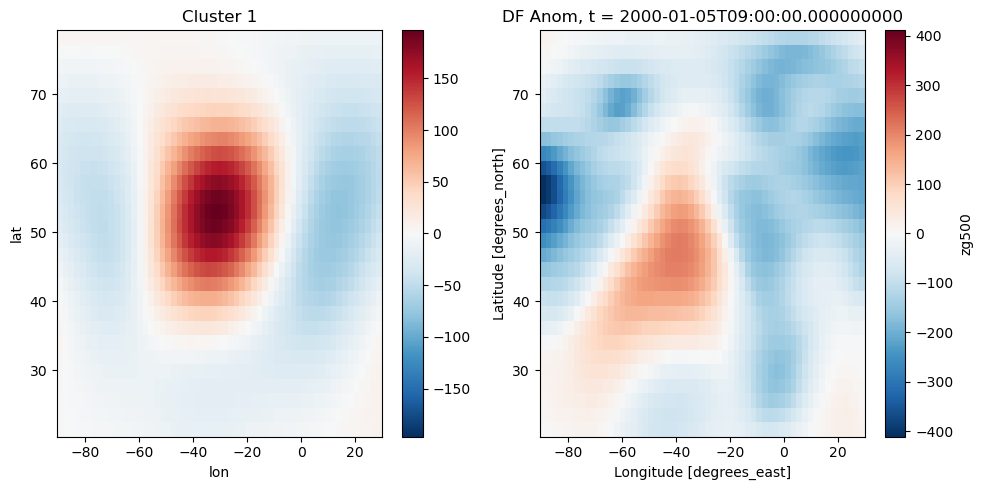

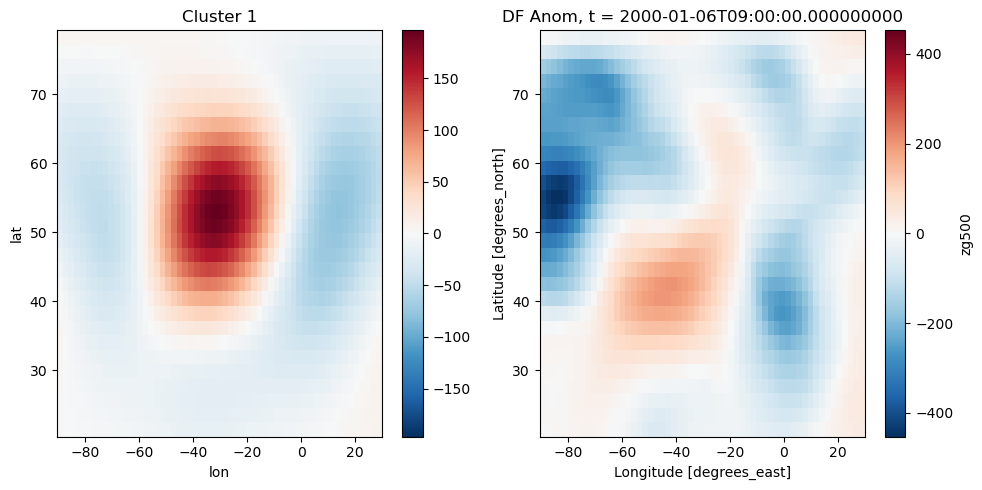

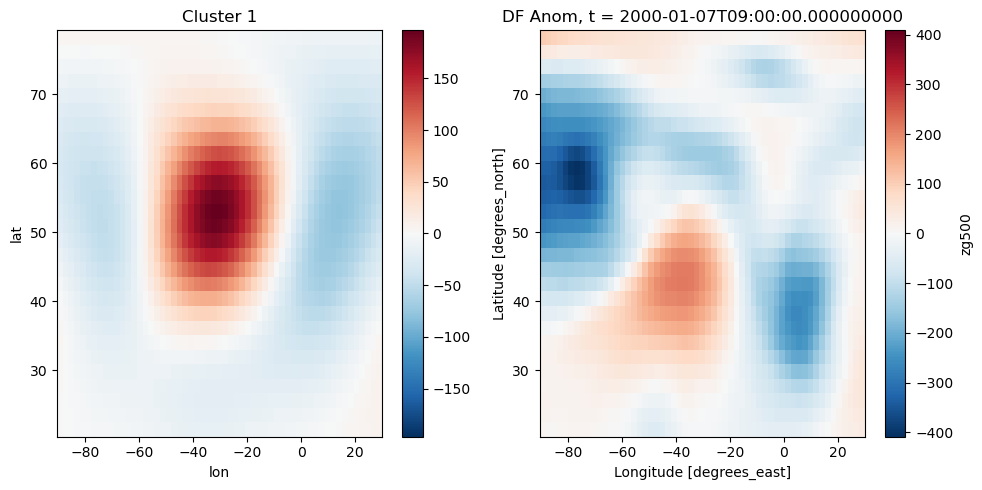

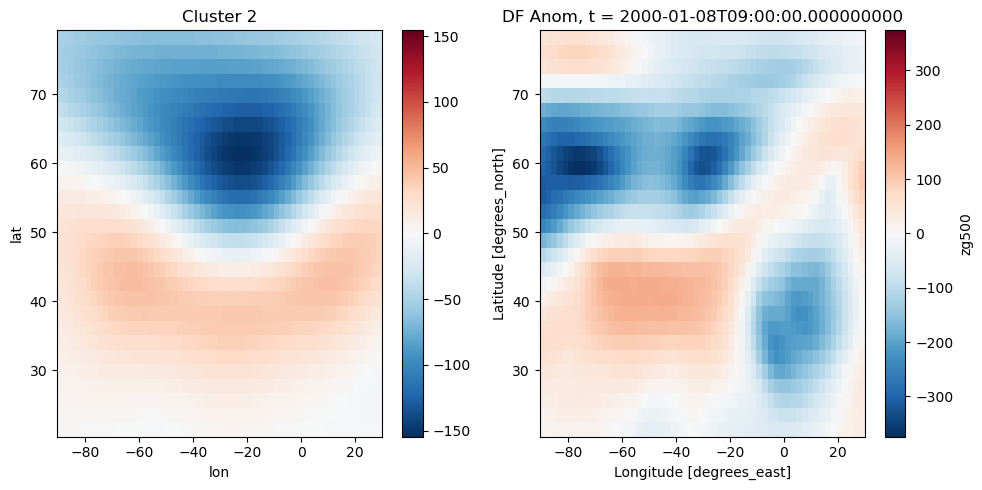

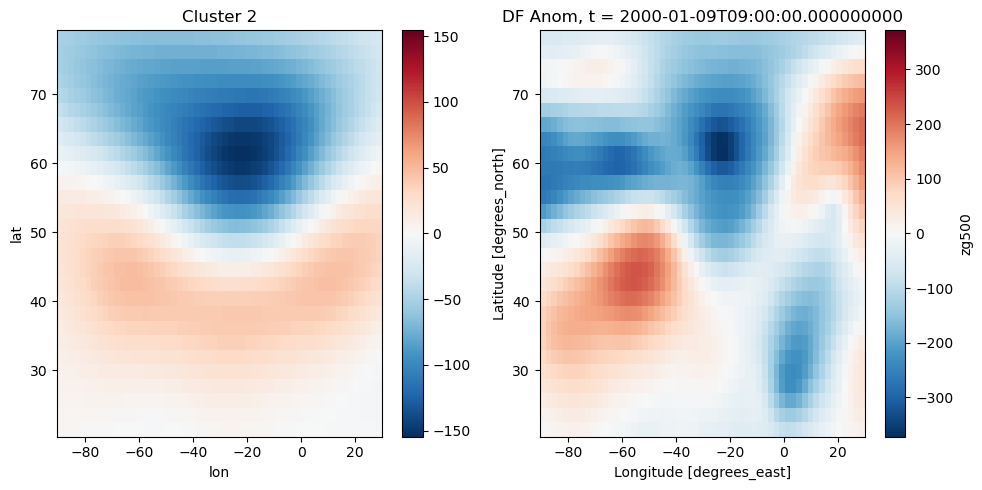

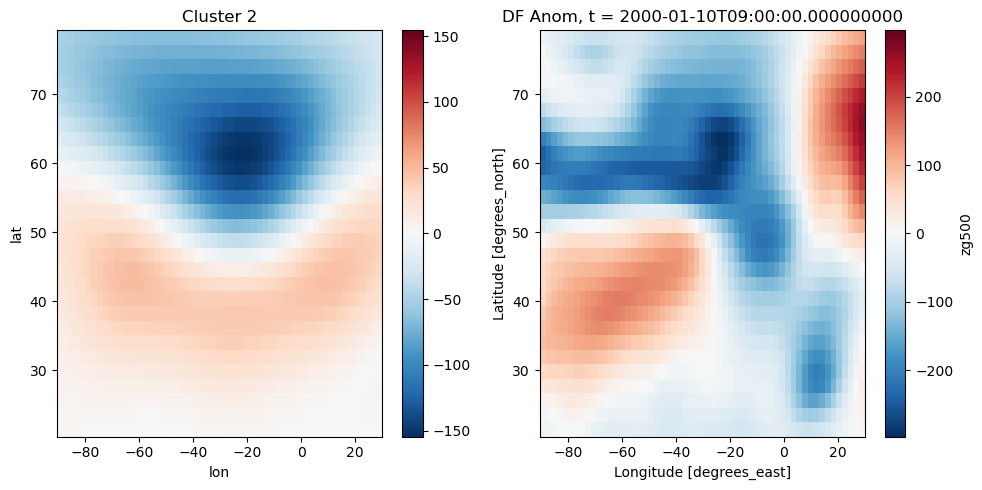

In [21]:
run = 10
centroids = cluster_center_array

df = load_data_per_run(run)    
df_anom = df.map_blocks(calculate_anomaly, template=df.load())
# df_anom['time'] = df_anom.indexes['time'].to_datetimeindex()
df_pcs = calculate_pcs(solver, df_anom)
X_assign = df_pcs.iloc[:, 0:N_EOFS_FOR_KMEANS].values

eof_origin = original_space(cluster_center_array, eofs)


for i in range(10):
    data_point = X_assign[i]

    distances = np.linalg.norm(data_point - cluster_center_array, axis=1)
    cluster_assignment = np.argmin(distances)
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    eof_origin[cluster_assignment].plot(ax=axs[0])
    axs[0].set_title(f'Cluster {cluster_assignment}')

    df_anom.isel(time = i).plot(ax=axs[1])
    axs[1].set_title(f'DF Anom, t = {df.time[i].values}')

    plt.tight_layout()
    plt.show()